**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The data set contains the following diseases:



*   Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion



In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import load_img



In [2]:
## To use the data by mounting the google drive, using the following :

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
root_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [4]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
#Visualize one instance of all the class present in the dataset.
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Lets do for Validation set now
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
## Lets do for test set to visualise the class present

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size )

Found 118 files belonging to 9 classes.


In [9]:
# Lets find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


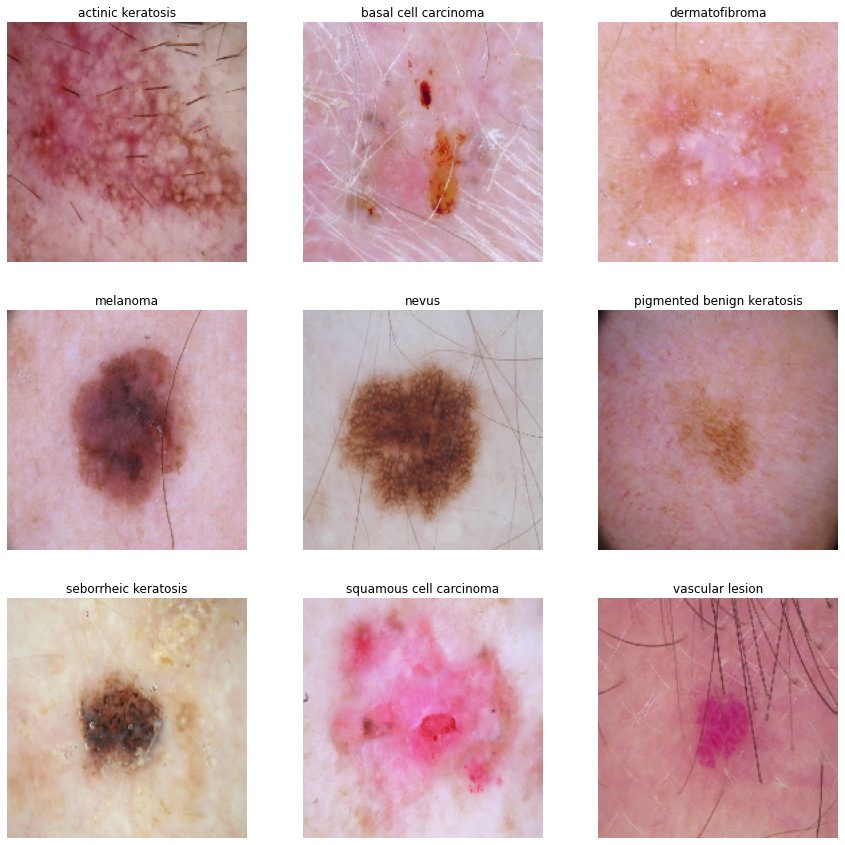

In [10]:
#Dictionary to store the path of image as per the class
#a code to visualize one instance of all the nine classes present in the dataset

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
### Standardizing values in [0,1]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
category_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))

**Create the model**

In [13]:
#CNN base Model Architecture
input_shape = (180,180,3)

#Sequential allows us to create models layer-by-layer  
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

#First Convulation layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Second Convulation layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten Layer
model.add(Flatten())

#Dense Layer
model.add(Dense(512, activation='relu'))

model.add(Activation('relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(9))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 41, 41, 64)        3

**Compile the model**


In [14]:
### choose an appropirate optimiser and loss function 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Train the model**


In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 291s 1s/step - loss: 1.9393 - accuracy: 0.3064 - val_loss: 1.6383 - val_accuracy: 0.4318
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: 1.6495 - accuracy: 0.4196 - val_loss: 1.5415 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 4s 63ms/step - loss: 1.5370 - accuracy: 0.4621 - val_loss: 1.4282 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 4s 63ms/step - loss: 1.4117 - accuracy: 0.4989 - val_loss: 1.4757 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 1.3377 - accuracy: 0.5285 - val_loss: 1.4296 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.2722 - accuracy: 0.5525 - val_loss: 1.3802 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 1.1539 - accuracy: 0.5932 - val_loss: 1.4514 - val_accuracy: 0.5414
Epoch 8/20
56

**Visualizing training results**


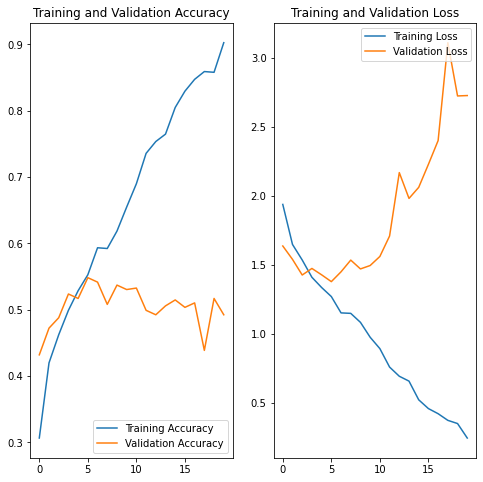

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 23ms/step - loss: 2.7276 - accuracy: 0.4922
Accuracy:  0.9291294813156128
Validation Accuracy:  0.4921700358390808
Loss:  0.19972722232341766
Validation Loss 2.7275795936584473


As we observed the model is **overfitting**, we can say this per below findings:

* After 20 epochs, The training accuracy ~ 90% but on the other hand validation accuracy is around 49%.
* With each epoch the validation loss is increasing and training loss is decreasing.

In [18]:
# Augmenting images by rotating, flipping, zooming, shearing, height-width shifting, and fill mode to be nearest 
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range            = 90.0,
    zoom_range                = [0.9,1.1],
    horizontal_flip           = [0.9,1.1],
    vertical_flip             = True,
    height_shift_range        = 10.0,
    width_shift_range         = 10.0,
    shear_range               = 5.0,
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',     
    validation_split          =0.2                     
    )
                                  

# Train data
train_generator = train_datagen.flow_from_directory(data_dir_train,
                                                    subset='training',                  
                                                    target_size=(180, 180),
                                                    batch_size = 32,
                                                    class_mode='categorical',
                                                    )

# Validation data
valid_generator = train_datagen.flow_from_directory(data_dir_train,
                                                    subset='validation',                 
                                                    target_size=(180, 180),
                                                    batch_size = 32,
                                                    class_mode='categorical',
                                                    )

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


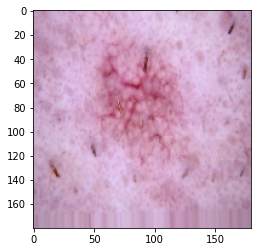

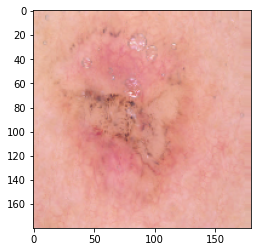

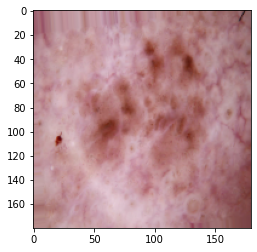

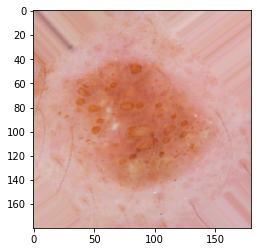

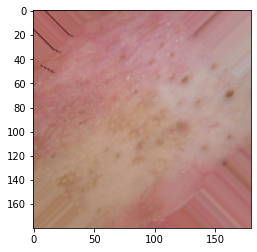

In [21]:
# Visualizing how augmentation strategy works for some training images
# Your code goes here
x_batch, y_batch = next(train_generator)

for i in range (0,5):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()   

**Create, compile and train the model**

In [22]:
## We can use Dropout layer if there is an evidence of overfitting in our findings

model2 = Sequential()
#First Convulation layer
model2.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu'))
model2.add(Activation('relu'))
#Second Convulation layer
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
# Max Pool size of 2*2
model2.add(MaxPooling2D(pool_size=(2, 2)))

#Third Convulation layer
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
#Fourth Convulation layer
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
# Max Pool size of 2*2
model2.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout layer with 15% Fraction of the input units to drop.
model2.add(Dropout(0.15))

#Fifth Convulation layer
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
#Sixth Convulation layer
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
# Max Pool size of 2*2
model2.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten Layer
model2.add(Flatten())
#Dense Layer
model2.add(Dense(512))
model2.add(Activation('relu'))
#Dense Layer
model2.add(Dense(128))
model2.add(Activation('relu'))
#Dropout layer with 15% Fraction of the input units to drop.

model2.add(Dropout(0.15))
model2.add(Dense(9))
model2.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 41, 41, 64)        3

**Compiling the model**

In [23]:
### choose an appropirate optimiser and loss function for second model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
## training second model for 20 epochs
epochs = 20
model2_history = model2.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  workers=12
)


Epoch 1/20
57/57 [==============================] - 53s 791ms/step - loss: 2.0743 - accuracy: 0.1939 - val_loss: 2.0165 - val_accuracy: 0.2072
Epoch 2/20
57/57 [==============================] - 47s 746ms/step - loss: 2.0301 - accuracy: 0.2072 - val_loss: 2.0059 - val_accuracy: 0.2072
Epoch 3/20
57/57 [==============================] - 47s 734ms/step - loss: 1.9881 - accuracy: 0.2474 - val_loss: 1.7714 - val_accuracy: 0.3356
Epoch 4/20
57/57 [==============================] - 47s 749ms/step - loss: 1.8132 - accuracy: 0.3226 - val_loss: 1.6518 - val_accuracy: 0.3649
Epoch 5/20
57/57 [==============================] - 47s 719ms/step - loss: 1.7953 - accuracy: 0.3432 - val_loss: 1.6319 - val_accuracy: 0.3806
Epoch 6/20
57/57 [==============================] - 49s 871ms/step - loss: 1.6583 - accuracy: 0.4095 - val_loss: 1.7661 - val_accuracy: 0.3941
Epoch 7/20
57/57 [==============================] - 47s 731ms/step - loss: 1.5766 - accuracy: 0.4507 - val_loss: 1.7701 - val_accuracy: 0.3694

<built-in method keys of dict object at 0x7fd7196ffa50> :


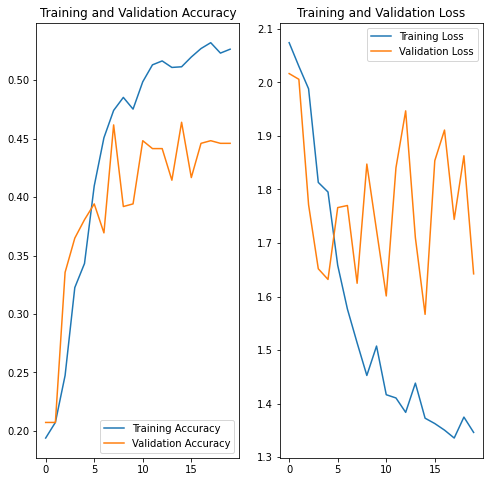

In [25]:
acc = model2_history.history['accuracy']
print(model2_history.history.keys, ":")
val_acc = model2_history.history['val_accuracy']

loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



* We can observe clearly this is a clear case of Underfitting. We reach to this conclusion be observiinig below findings
  * Training and Validation accuracy are closely following each other. However, both are aroound 50%
  *  Both the losses are less. 
*  By Augmentation, overfitting can be handled

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.




Found 2239 files belonging to 9 classes.


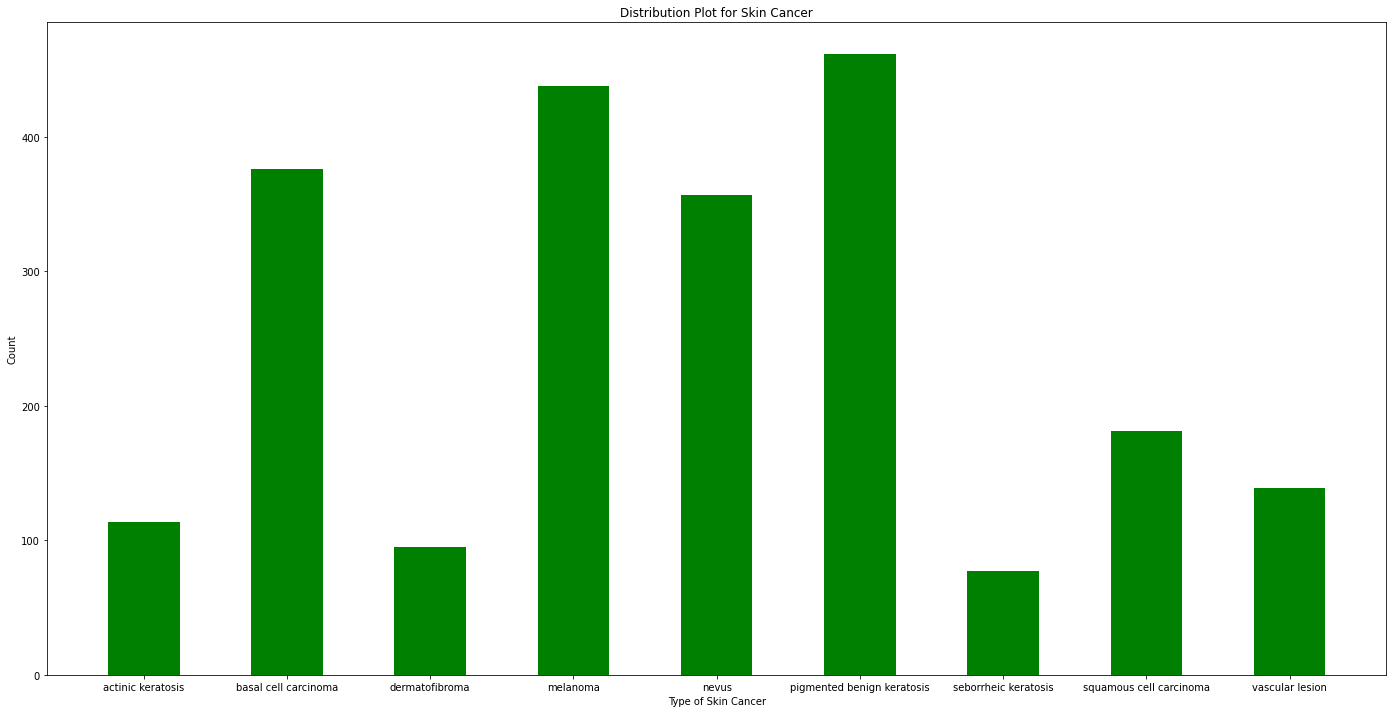

In [28]:
# visualize how your augmentation strategy works for one instance of training image.
# reading the entire training dataset 
# Checking distribution of classes in the training dataset.
import tensorflow_datasets as tfds

train_ds_plot = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    )

train_ds_plot = train_ds_plot.map(lambda x, y: (normalization_layer(x), category_layer(y)))

# converting to numpy array
train_np = tfds.as_numpy(train_ds_plot)

distribution = []

# creating a dictionary obj to calculate the count of each skin cancer type
class_dist = dict()
for features_labels in train_np:
    for row in features_labels[1]:
        distribution.append(row)

dist_df = pd.DataFrame(distribution)   
dist_df.columns = class_names

# calculating count of eachtype
for cls in class_names:
    class_dist[cls] = dist_df[cls].sum()
    
keys = list(class_dist.keys())
values = list(class_dist.values())
  
# plotting distribution
fig = plt.figure(figsize = (24, 12)) 
plt.bar(keys, values, color ='green', width = 0.5) 
plt.xlabel("Type of Skin Cancer")
plt.ylabel("Count")
plt.title("Distribution Plot for Skin Cancer")
plt.show()

**Rectify the class imbalance**
**Context**: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.
- Which class has the least number of samples? - *Seborrheic keratosis*
- Which classes dominate the data in terms proportionate number of samples?
- **pigmented benign keratosis** dominates the data of count more than 100 in training

In [29]:
!pip install Augmentor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**To use Augmentor, the following general procedure is followed:**

- Instantiate a Pipeline object pointing to a directory containing your initial image data set.
- Define a number of operations to perform on this data set using your Pipeline object.
- Execute these operations by calling the Pipeline’s sample() method.

In [30]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD84213D950>: 100%|██████████| 500/500 [00:20<00:00, 24.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD707F9A250>: 100%|██████████| 500/500 [00:25<00:00, 19.94 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD7078D2150>: 100%|██████████| 500/500 [00:24<00:00, 20.46 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD70782F490>: 100%|██████████| 500/500 [01:35<00:00,  5.23 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=796x682 at 0x7FD7078DBF50>: 100%|██████████| 500/500 [01:17<00:00,  6.43 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD705E040D0>: 100%|██████████| 500/500 [00:18<00:00, 27.75 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD705A16ED0>: 100%|██████████| 500/500 [00:43<00:00, 11.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD706DDFB10>: 100%|██████████| 500/500 [00:18<00:00, 27.75 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD706DC3250>: 100%|██████████| 500/500 [00:18<00:00, 27.75 Samples/s]


In [31]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_a8368ae2-e26f-4099-b7ef-1785ea6f566f.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_51426bbe-531c-45da-a1c0-1c68ee0c8070.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_b7927a9b-30ef-4a79-8f8f-4c3fd9da27c0.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_91d172cc-beaf-4fe4-9321-2a2c9c505eb9.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Co

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [36]:
new_df['Label'].value_counts()


actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

Now, we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.



**Train the model on the data created using Augmentor**

In [37]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [38]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Create a validation dataset**

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create model with normalization**

In [40]:
# normalization
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
category_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))

In [42]:
model3 = Sequential( 
    [tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)])

## simple model works better with more data

model3.add(Conv2D(16, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2))) # 

model3.add(Conv2D(32, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
# Adding Dropout Layer
model3.add(Dropout(0.40))

model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dense(9))
model3.add(Activation('softmax'))

#model3.summary()

**Compiling the model**

In [44]:
# choose an appropirate optimiser and loss function f0r third  mdel

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Train the model**

In [45]:
epochs = 30

model3_history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  workers=12
  )

Epoch 1/30
169/169 [==============================] - 33s 180ms/step - loss: 1.9559 - accuracy: 0.2468 - val_loss: 1.5895 - val_accuracy: 0.4217
Epoch 2/30
169/169 [==============================] - 31s 176ms/step - loss: 1.5378 - accuracy: 0.4164 - val_loss: 1.4086 - val_accuracy: 0.4722
Epoch 3/30
169/169 [==============================] - 30s 172ms/step - loss: 1.3872 - accuracy: 0.4701 - val_loss: 1.3207 - val_accuracy: 0.5011
Epoch 4/30
169/169 [==============================] - 30s 174ms/step - loss: 1.2809 - accuracy: 0.5119 - val_loss: 1.2527 - val_accuracy: 0.5293
Epoch 5/30
169/169 [==============================] - 35s 201ms/step - loss: 1.2008 - accuracy: 0.5352 - val_loss: 1.1554 - val_accuracy: 0.5880
Epoch 6/30
169/169 [==============================] - 31s 176ms/step - loss: 1.1181 - accuracy: 0.5734 - val_loss: 1.0496 - val_accuracy: 0.6154
Epoch 7/30
169/169 [==============================] - 36s 208ms/step - loss: 1.0877 - accuracy: 0.5916 - val_loss: 1.2113 - val_ac

**Visualizing the results**

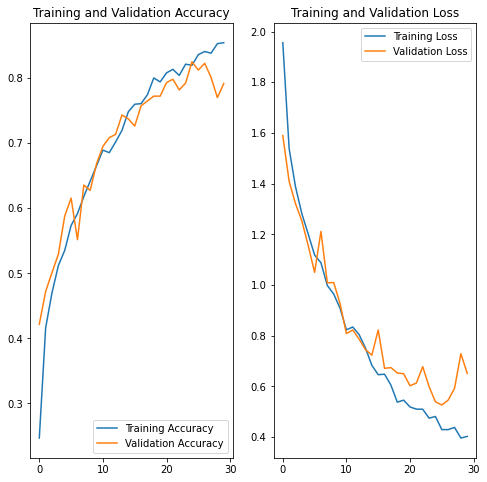

In [46]:
acc = model3_history.history['accuracy']
val_acc = model3_history.history['val_accuracy']

loss = model3_history.history['loss']
val_loss = model3_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



**Did you get rid of underfitting/overfitting? Did class rebalance help?**

*   The class rebalance using Augmentor library helped in reducing both overfititng as well as underfitting of the data 
*   Initially we tried without the ImageDataGenerator which created data to over fit at high ratio
*   Then we introduced dropout and ImageDataGenerator which reduced the overfit
At last we tried Batch Normalization and Augumentation which looks good

Observations :-
- After 30 epochs,  The third model gives us around below accuracies: 
  - Training accuracy - 85.42% 
  - Validation accuracy - 79.14% 
- We can observe that the model is a good fit per the graph therefore both overfitting and underfitting are handled well.
